In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plot
from matplotlib import cm, rcParams
import tensorflow as tf

# Set up the colormap and default settings
cmap = cm.get_cmap('plasma')
rcParams.update({'font.size': 12})

# Load place cell and reward cell network data
with open('pcn.pkl', 'rb') as f:
    pc_net = pickle.load(f)
with open('rcn.pkl', 'rb') as f:
    rc_net = pickle.load(f)

# Load environment data (place cell and reward map coordinates)
with open('hmap_x.pkl', 'rb') as f:
    hmap_x = pickle.load(f)
with open('hmap_y.pkl', 'rb') as f:
    hmap_y = pickle.load(f)
with open('hmap_z_small.pkl', 'rb') as f:
    hmap_z_small = np.asarray(pickle.load(f))
with open('hmap_z_large.pkl', 'rb') as f:
    hmap_z_large = np.asarray(pickle.load(f))
with open('hmap_g.pkl', 'rb') as f:
    hmap_g = np.asarray(pickle.load(f))
with open('hmap_vis_density.pkl', 'rb') as f:
    hmap_vis_density = np.asarray(pickle.load(f))

goal_r = 0.3  # Define goal radius
goalLocation = [-1, 1]  # Define goal location (can be updated)

C:\Users\bduke\AppData\Local\Temp\ipykernel_26900\3041171533.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('plasma')


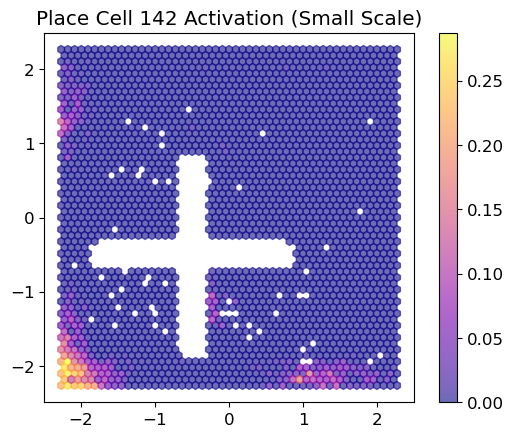

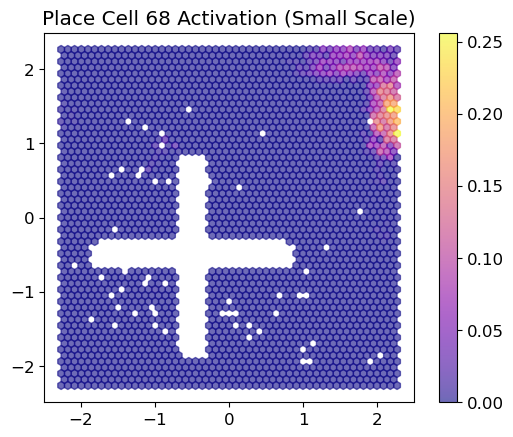

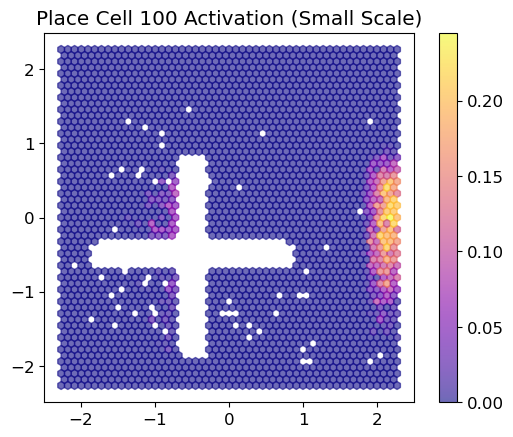

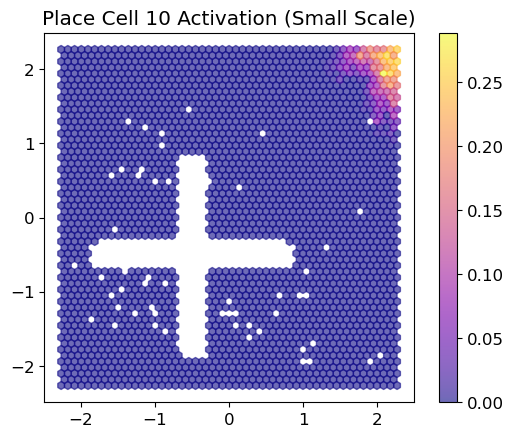

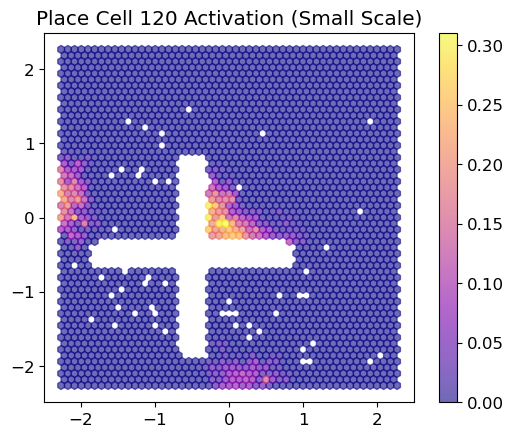

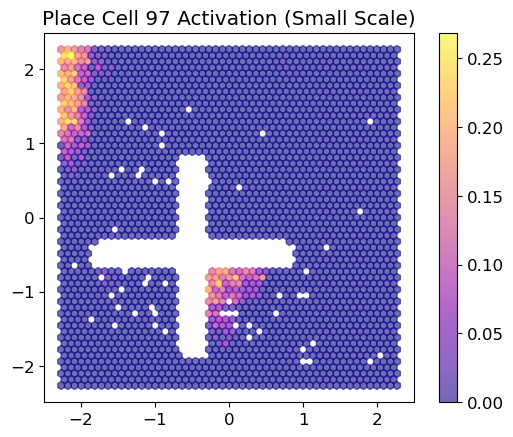

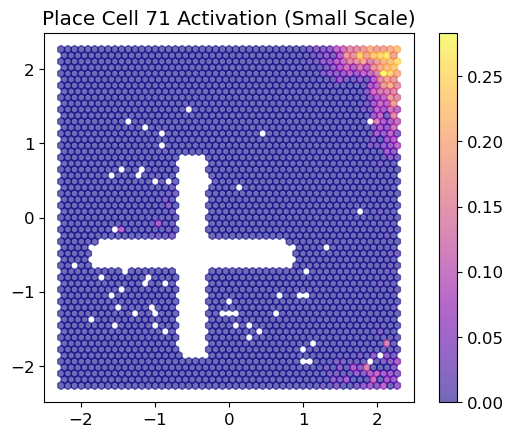

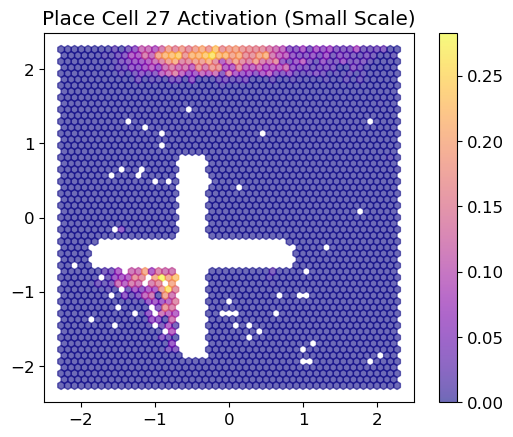

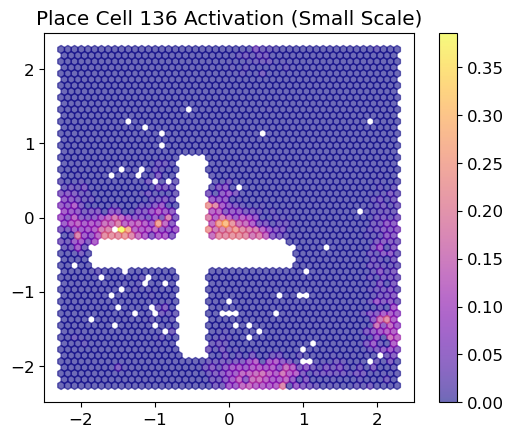

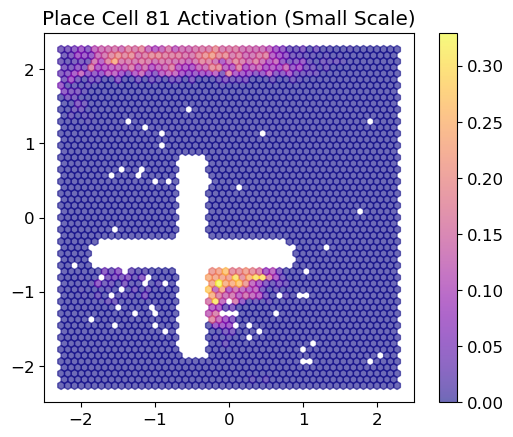

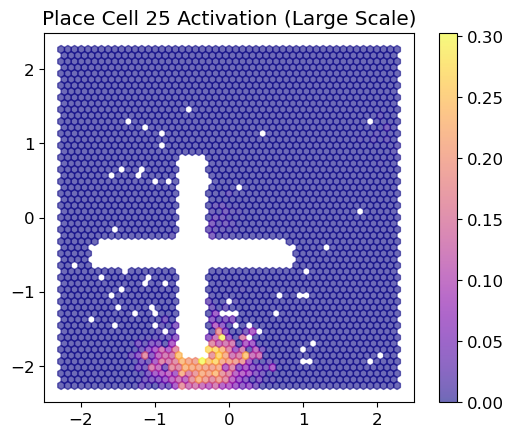

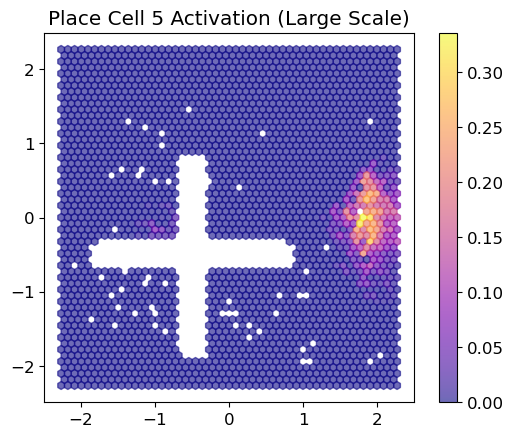

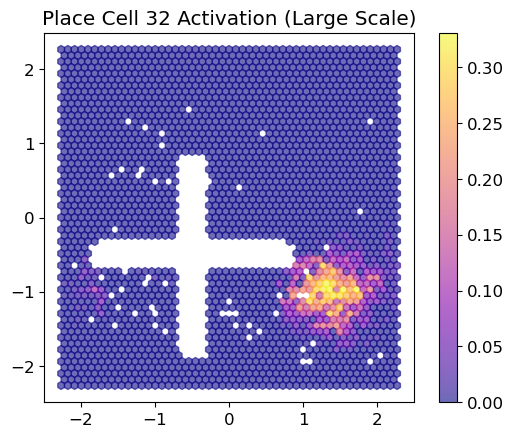

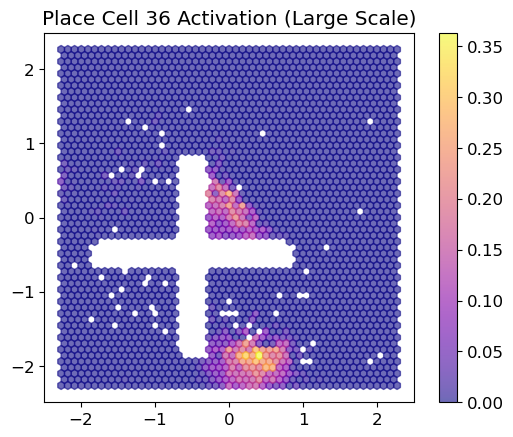

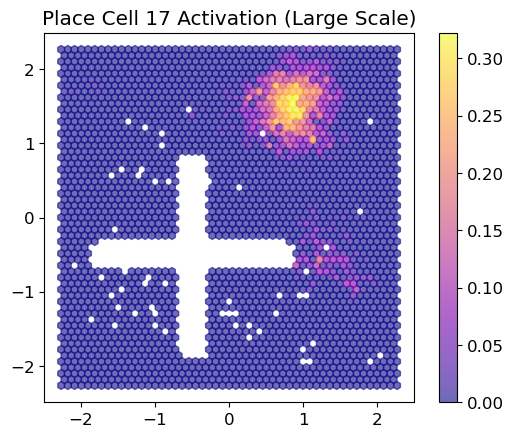

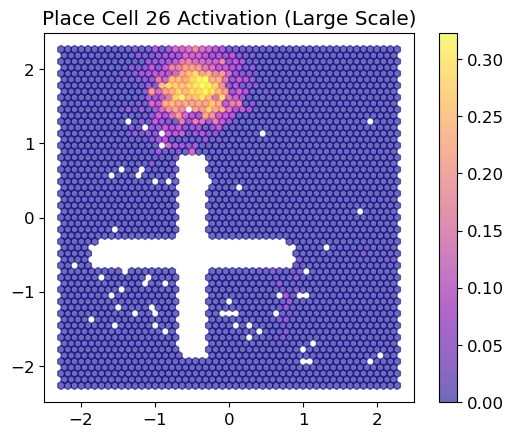

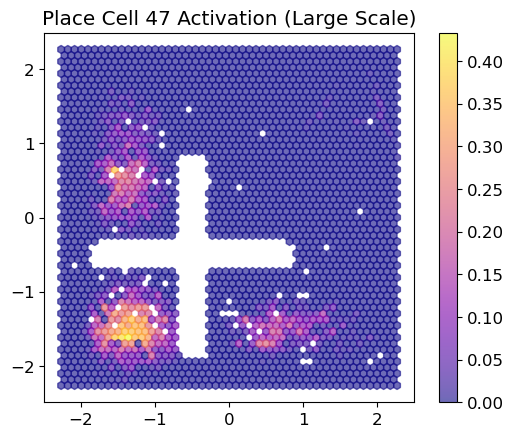

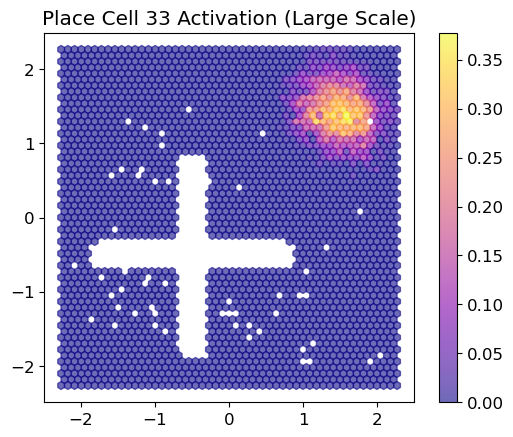

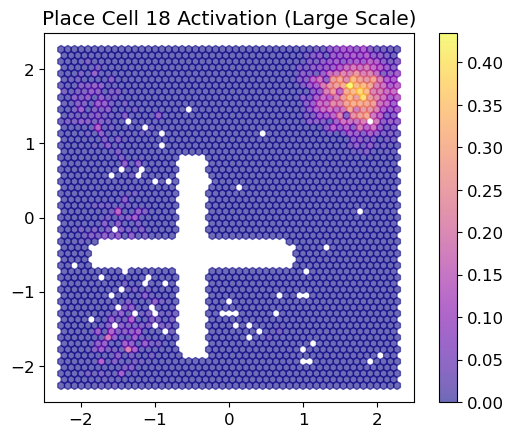

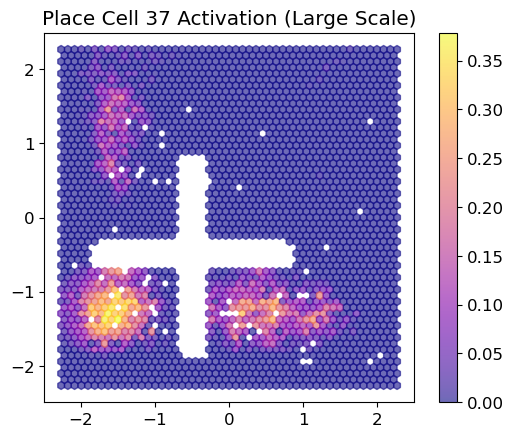

In [13]:
def probeOne(probed, scale="small"):
    """
    Visualizes the activation of a specific place cell (probed) over the environment map.

    Parameters:
    - probed (int): The index of the place cell to visualize.
    - scale (str): The scale of the place cell, either "small" or "large".
    """
    if scale == "small":
        activations = hmap_z_small[:, probed]
    elif scale == "large":
        activations = hmap_z_large[:, probed]
    else:
        raise ValueError("Invalid scale. Use 'small' or 'large'.")

    # Plot the activations
    fig = plot.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")

    # Create a hexbin plot for place cell activations
    cntr = ax.hexbin(hmap_x, hmap_y, activations, gridsize=50, cmap=cmap, alpha=0.6)

    # Add colorbar and title
    plot.colorbar(cntr)
    v = f"v_{{{probed}}}^p ({scale.capitalize()} Scale)"
    plot.title(f"Place Cell {probed} Activation ({scale.capitalize()} Scale)")
    plot.show()

# Calculate the total activation for each scale
total_activations_small = np.sum(hmap_z_small, axis=0)
total_activations_large = np.sum(hmap_z_large, axis=0) if hmap_z_large is not None else []

# Get the indices of the top 10 most activated place cells for each scale
top_10_small_cells = np.argsort(total_activations_small)[-10:]
top_10_large_cells = np.argsort(total_activations_large)[-10:] if len(total_activations_large) > 0 else []

# Plot the activations for the top 10 place cells in the small scale
for cell in top_10_small_cells:
    probeOne(cell, scale="small")

# Plot the activations for the top 10 place cells in the large scale
if hmap_z_large is not None:
    for cell in top_10_large_cells:
        probeOne(cell, scale="large")


In [ ]:
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

def plot_rcn_activation(context=0):
    """
    Visualizes the reward cell activations across the environment.

    Parameters:
    context (int): Context index for the reward cell weights.
    """
    # Load the RCN layer (reward cell network)
    with open('rcn.pkl', 'rb') as f:
        rc_net = pickle.load(f)

    # Compute the total place cell activations to use in normalizing the reward activations
    sum_activations = tf.reduce_sum(hmap_z, axis=-1)
    safe_denominator = tf.where(sum_activations > 0, sum_activations, 1)  # Avoid division by zero

    # Ensure that both tensors are float32 for tensordot and division
    hmap_z_float32 = tf.cast(hmap_z.T, tf.float32)  # Transpose and cast hmap_z to float32
    w_in_effective_float32 = tf.cast(rc_net.w_in_effective, tf.float32)  # Cast rc_net effective weights to float32
    safe_denominator = tf.cast(safe_denominator, tf.float32)  # Cast safe_denominator to float32

    # Compute the reward function using the RCN effective weights and the place cell activations
    reward_function = tf.tensordot(w_in_effective_float32[context], hmap_z_float32, axes=1) / safe_denominator

    # Flatten reward function to ensure it's a 1D array
    reward_function = tf.squeeze(reward_function)

    # Check if reward_function has the same shape as hmap_x and hmap_y
    if reward_function.shape != hmap_x.shape:
        raise ValueError(f"Shape mismatch: reward_function has shape {reward_function.shape}, but expected {hmap_x.shape}.")

    # Plot the reward function over the environment
    fig, ax = plt.subplots(dpi=150)
    ax.set_aspect('equal')

    # Create a hexbin plot for the reward activations
    cntr = ax.hexbin(hmap_x, hmap_y, reward_function.numpy(), gridsize=50, cmap=cmap, alpha=0.6)

    # Rotate the plot by 180 degrees by reversing the x and y limits
    ax.set_ylim(5, -5)
    ax.set_xlim(5, -5)
    ax.set_axis_off()

    # Increase the size of the map relative to the overall plot
    fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

    # Draw the goal location as a green circle
    goal = plt.Circle(goalLocation, goal_r, color='green', alpha=0.5, fill=True)
    ax.add_patch(goal)

    # Add a colorbar for the reward values
    fig.colorbar(cntr)
    plt.title(f"Reward Map Visualization for context {context}")
    plt.show()

# Call the function with a specific context
#plot_rcn_activation(context=0)


ValueError: Shape mismatch: reward_function has shape (14363,), but expected (12414,).

In [ ]:
def plot_vis_density(hmap_x, hmap_y, hmap_vis_density):
    """
    Visualizes the visual density over the environment map using hexbin plotting.

    Parameters:
    - hmap_x (np.ndarray): X-coordinates of the robot's trajectory.
    - hmap_y (np.ndarray): Y-coordinates of the robot's trajectory.
    - hmap_vis_density (np.ndarray): Visual density values at each step.
    """
    # Set up the plot
    cmap = get_cmap("plasma")  # Use the plasma colormap
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.set_aspect("equal")
    ax.set_title("Visual Density Map")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")

    # Create a hexbin plot for visual density
    hb = ax.hexbin(
        hmap_x, hmap_y, hmap_vis_density, gridsize=50, cmap=cmap, reduce_C_function=np.mean, alpha=0.8
    )

    # Add colorbar and labels
    cb = plt.colorbar(hb, ax=ax)
    cb.set_label("Visual Density")
    
    # Show the plot
    plt.show()

plot_vis_density(hmap_x, hmap_y, hmap_vis_density)

[0.01159669 0.01164663 0.01167193 0.0118983  0.01256356 0.01318858
 0.01333399 0.01335987 0.01432186 0.01433277 0.01441542 0.01510876
 0.01556589 0.01648361 0.01722877 0.0177889  0.01779047 0.01956742
 0.01984699 0.02203139 0.02273799 0.02358951 0.02683357 0.02754163
 0.03063076 0.03249511 0.03335011 0.04213097 0.05332967 0.07176123
 0.11251757 0.12336321 0.15672435 0.18326448 0.22731733 0.3415689
 0.35503855 0.39246163 0.6262571  1.1277833 ]
